<h2><u>Question-6: Variational AutoEncoder</u></h2>


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, latent_dim),
            nn.ReLU()
        )

        self.mean_layer = nn.Linear(latent_dim, 2)
        self.var_layer = nn.Linear(latent_dim, 2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, var = self.mean_layer(x), self.var_layer(x)
        return mean, var

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, var = self.encode(x)
        z = self.reparameterization(mean, var)
        x_hat = self.decode(z)
        return x_hat, mean, var

    def loss_function(self, x, x_hat, mean, var):
        reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        KLD = - 0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())

        return reproduction_loss + KLD

In [ ]:
transform = transforms.ToTensor()

train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
print(len(train))

test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
print(len(test))

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.22MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.45MB/s]

60000
10000


In [ ]:
vae = VAE(latent_dim=200).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (x, label) in enumerate(train_loader):
        x = x.to(x).view(-1, 28*28)
        optimizer.zero_grad()

        x_pred, mu, var = vae(x)
        x_pred = torch.clamp(x_pred, min=1e-9, max=1)
        loss = vae.loss_function(x, x_pred, mu, var)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 169.9155
Epoch 2, Loss: 148.8966
Epoch 3, Loss: 144.6261
Epoch 4, Loss: 142.2265
Epoch 5, Loss: 140.5747
Epoch 6, Loss: 139.2420
Epoch 7, Loss: 138.2333
Epoch 8, Loss: 137.2510
Epoch 9, Loss: 136.8599
Epoch 10, Loss: 136.1267
Epoch 11, Loss: 135.7938
Epoch 12, Loss: 135.1737
Epoch 13, Loss: 135.0419
Epoch 14, Loss: 134.9577
Epoch 15, Loss: 134.4428
Epoch 16, Loss: 134.1554
Epoch 17, Loss: 133.7943
Epoch 18, Loss: 133.3107
Epoch 19, Loss: 133.6593
Epoch 20, Loss: 133.3714
Epoch 21, Loss: 132.6143
Epoch 22, Loss: 132.6554
Epoch 23, Loss: 132.3684
Epoch 24, Loss: 132.2489
Epoch 25, Loss: 132.2475
Epoch 26, Loss: 131.7348
Epoch 27, Loss: 131.3190
Epoch 28, Loss: 131.4098
Epoch 29, Loss: 131.1592
Epoch 30, Loss: 131.4225
Epoch 31, Loss: 130.7861
Epoch 32, Loss: 131.3787
Epoch 33, Loss: 133.0442
Epoch 34, Loss: 131.8375
Epoch 35, Loss: 131.5300
Epoch 36, Loss: 131.6677
Epoch 37, Loss: 130.6625
Epoch 38, Loss: 130.3951
Epoch 39, Loss: 130.0170
Epoch 40, Loss: 129.7958
Epoch 41,

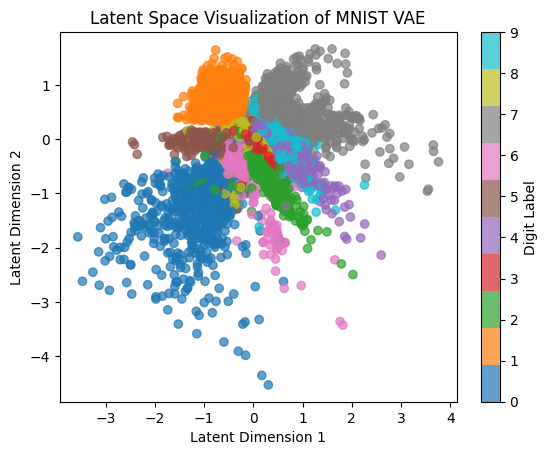

In [ ]:
vae.eval()
with torch.no_grad():
    latents, labels = [], []
    for x, target in test_loader:
        x = x.to(device).view(-1, 28*28)
        mu, var = vae.encode(x)
        latents.append(mu.cpu().numpy())
        labels.append(target.numpy())
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    plt.figure()
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization of MNIST VAE')
    plt.show()

Epoch 1, Loss: 0.0000
Epoch 2, Loss: 0.0000
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000
Epoch 11, Loss: 0.0000
Epoch 12, Loss: 0.0000
Epoch 13, Loss: 0.0000
Epoch 14, Loss: 0.0000
Epoch 15, Loss: 0.0000
Epoch 16, Loss: 0.0000
Epoch 17, Loss: 0.0000
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000
Epoch 21, Loss: 0.0000
Epoch 22, Loss: 0.0000
Epoch 23, Loss: 0.0000
Epoch 24, Loss: 0.0000
Epoch 25, Loss: 0.0000
Epoch 26, Loss: 0.0000
Epoch 27, Loss: 0.0000
Epoch 28, Loss: 0.0000
Epoch 29, Loss: 0.0000
Epoch 30, Loss: 0.0000
Epoch 31, Loss: 0.0000
Epoch 32, Loss: 0.0000
Epoch 33, Loss: 0.0000
Epoch 34, Loss: 0.0000
Epoch 35, Loss: 0.0000
Epoch 36, Loss: 0.0000
Epoch 37, Loss: 0.0000
Epoch 38, Loss: 0.0000
Epoch 39, Loss: 0.0000
Epoch 40, Loss: 0.0000
Epoch 41, Loss: 0.0000
Epoch 42, Loss: 0.0000
Epoch 43, Loss: 0.0000
Epoch 44, Loss: 0.00

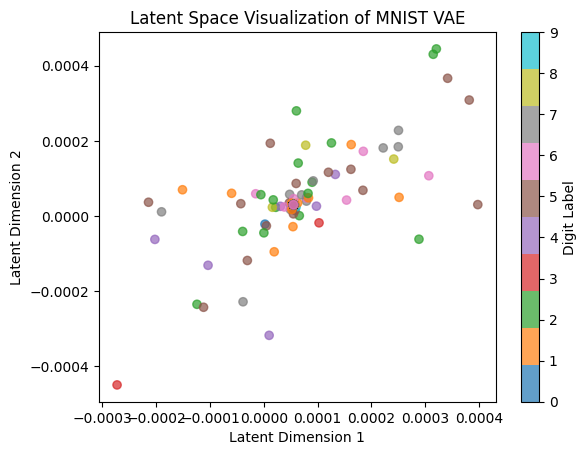

In [ ]:
def only_kl(x, x_hat, mean, var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())

    return KLD

vae = VAE(latent_dim=200).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (x, label) in enumerate(train_loader):
        x = x.to(x).view(-1, 28*28)
        optimizer.zero_grad()

        x_pred, mu, var = vae(x)
        x_pred = torch.clamp(x_pred, min=1e-9, max=1)
        loss = only_kl(x, x_pred, mu, var)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

vae.eval()
with torch.no_grad():
    latents, labels = [], []
    for x, target in test_loader:
        x = x.to(device).view(-1, 28*28)
        mu, var = vae.encode(x)
        latents.append(mu.cpu().numpy())
        labels.append(target.numpy())
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    plt.figure()
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization of MNIST VAE')
    plt.show()

<h4><u>Report</u></h4>


*   The reconstruction loss is important for ensuring that the decoded output is close to the original input.
*   Without the reconstruction loss, we see that model does not learn any meaningful information since it is not penalised for creating outputs that are not close to the input.
* Due to only the KL Divergence loss, the model only learns to produce points that match a normal distribution - thus explaining the clustered points around the mean.
* Thus, the reconstruction loss is important for learning meaningful associations in the data.



Epoch 1, Loss: 166.8761
Epoch 2, Loss: 147.6243
Epoch 3, Loss: 143.4664
Epoch 4, Loss: 140.8336
Epoch 5, Loss: 138.8284
Epoch 6, Loss: 137.8755
Epoch 7, Loss: 136.9848
Epoch 8, Loss: 136.9395
Epoch 9, Loss: 135.4683
Epoch 10, Loss: 134.9615
Epoch 11, Loss: 133.9475
Epoch 12, Loss: 133.8775
Epoch 13, Loss: 133.0404
Epoch 14, Loss: 132.9332
Epoch 15, Loss: 132.5989
Epoch 16, Loss: 132.1178
Epoch 17, Loss: 131.6177
Epoch 18, Loss: 131.5284
Epoch 19, Loss: 131.4843
Epoch 20, Loss: 131.2022
Epoch 21, Loss: 131.0493
Epoch 22, Loss: 130.6852
Epoch 23, Loss: 130.1798
Epoch 24, Loss: 130.1467
Epoch 25, Loss: 129.9479
Epoch 26, Loss: 129.7467
Epoch 27, Loss: 130.1910
Epoch 28, Loss: 129.4835
Epoch 29, Loss: 129.4080
Epoch 30, Loss: 130.8019
Epoch 31, Loss: 129.4603
Epoch 32, Loss: 129.0018
Epoch 33, Loss: 128.6706
Epoch 34, Loss: 128.7204
Epoch 35, Loss: 129.0810
Epoch 36, Loss: 128.7007
Epoch 37, Loss: 128.4046
Epoch 38, Loss: 128.5724
Epoch 39, Loss: 128.3027
Epoch 40, Loss: 127.9263
Epoch 41,

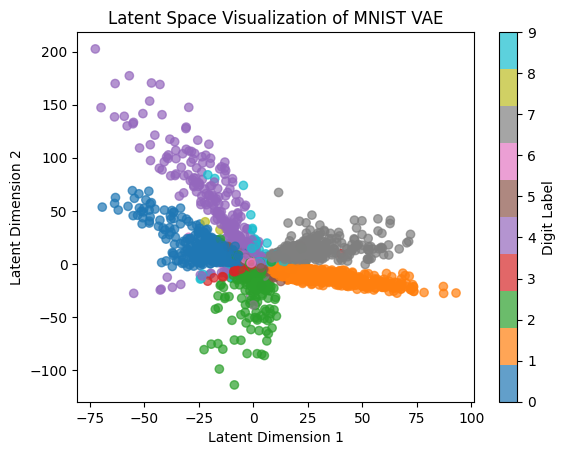

In [ ]:
def only_bce(x, x_hat, mean, var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # KLD = - 0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())

    return reproduction_loss

vae = VAE(latent_dim=200).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (x, label) in enumerate(train_loader):
        x = x.to(x).view(-1, 28*28)
        optimizer.zero_grad()

        x_pred, mu, var = vae(x)
        x_pred = torch.clamp(x_pred, min=1e-9, max=1)
        loss = only_bce(x, x_pred, mu, var)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

vae.eval()
with torch.no_grad():
    latents, labels = [], []
    for x, target in test_loader:
        x = x.to(device).view(-1, 28*28)
        mu, var = vae.encode(x)
        latents.append(mu.cpu().numpy())
        labels.append(target.numpy())
    latents = np.concatenate(latents)
    labels = np.concatenate(labels)

    plt.figure()
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit Label')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization of MNIST VAE')
    plt.show()

<h4><u>Report</u></h4>


*   The KL Divergence loss term regularizes the latent space by keeping it close to a standard normal distribtuion.
*   Without this loss, we notice that the model spreads out in the latent space leading to unbounded values. Thus, it behaves jsut like an autoencoder.
* Eventhough the model learns distinct latent representations for the digits, it is not generative because sampling random points from this unregularized latent space will give valid outputs.
* Thus, without the KL divergence term, though the model learns to discriminate between the digits, we cannot sample latent points and generate meaningful data.



Epoch 1, Loss: 170.2396
Epoch 2, Loss: 149.2285
Epoch 3, Loss: 144.1632
Epoch 4, Loss: 141.5899
Epoch 5, Loss: 140.1325
Epoch 6, Loss: 138.7278
Epoch 7, Loss: 137.9180
Epoch 8, Loss: 136.7357
Epoch 9, Loss: 136.2368
Epoch 10, Loss: 135.5293
Epoch 11, Loss: 134.9083
Epoch 12, Loss: 134.7829
Epoch 13, Loss: 134.1835
Epoch 14, Loss: 133.8846
Epoch 15, Loss: 133.5540
Epoch 16, Loss: 133.7700
Epoch 17, Loss: 133.5453
Epoch 18, Loss: 132.9912
Epoch 19, Loss: 132.2300
Epoch 20, Loss: 132.3762
Epoch 21, Loss: 132.4665
Epoch 22, Loss: 131.9449
Epoch 23, Loss: 132.0948
Epoch 24, Loss: 131.5028
Epoch 25, Loss: 131.6306
Epoch 26, Loss: 131.7794
Epoch 27, Loss: 131.4943
Epoch 28, Loss: 131.2036
Epoch 29, Loss: 130.9274
Epoch 30, Loss: 130.9633
Epoch 31, Loss: 131.7407
Epoch 32, Loss: 131.4522
Epoch 33, Loss: 132.0714
Epoch 34, Loss: 131.6627
Epoch 35, Loss: 131.3216
Epoch 36, Loss: 130.9042
Epoch 37, Loss: 130.2048
Epoch 38, Loss: 130.4423
Epoch 39, Loss: 130.6194
Epoch 40, Loss: 130.4369
Epoch 41,

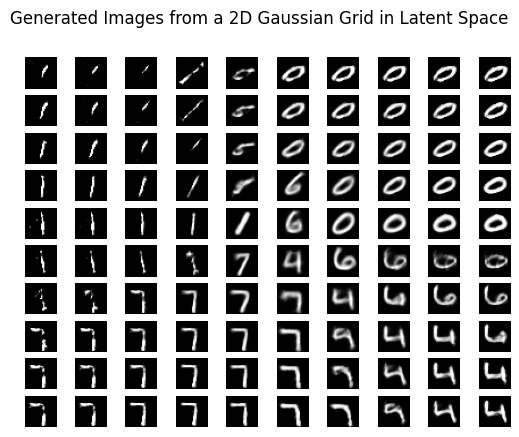

In [ ]:
vae = VAE(latent_dim=200).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (x, label) in enumerate(train_loader):
        x = x.to(x).view(-1, 28*28)
        optimizer.zero_grad()

        x_pred, mu, var = vae(x)
        x_pred = torch.clamp(x_pred, min=1e-9, max=1)
        loss = vae.loss_function(x, x_pred, mu, var)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
vae.eval()

grid_x = np.linspace(-5, 5, 10)
grid_y = np.linspace(-5, 5, 10)
z_grid = np.array([[x, y] for y in grid_y for x in grid_x], dtype=np.float32)
z_tensor = torch.tensor(z_grid, device=device)

with torch.no_grad():
     x_hat = vae.decode(z_tensor).cpu().numpy()

fig, axes = plt.subplots(10, 10)
for i, ax in enumerate(axes.flat):
    ax.imshow(x_hat[i].reshape(28, 28), cmap="gray")
    ax.axis("off")

plt.suptitle("Generated Images from a 2D Gaussian Grid in Latent Space")
plt.show()

<h4><u>Report</u></h4>


*   The above grid visualisation shows that the VAE has tried to map the digits to a continuous latent space.
*   We see that digits with roughly the same shape are placed closer together and they morph into one another.
* Some locations mappear fuzzy, probably because they are “boundary” regions between digit clusters.



Epoch 1, Loss: 40.9169
Epoch 2, Loss: 34.3915
Epoch 3, Loss: 32.5475
Epoch 4, Loss: 31.5545
Epoch 5, Loss: 30.8399
Epoch 6, Loss: 30.4177
Epoch 7, Loss: 30.0284
Epoch 8, Loss: 29.6735
Epoch 9, Loss: 29.5190
Epoch 10, Loss: 29.2653
Epoch 11, Loss: 29.1026
Epoch 12, Loss: 28.8959
Epoch 13, Loss: 28.9440
Epoch 14, Loss: 28.5720
Epoch 15, Loss: 28.5210
Epoch 16, Loss: 28.3986
Epoch 17, Loss: 28.2612
Epoch 18, Loss: 28.0704
Epoch 19, Loss: 27.9899
Epoch 20, Loss: 27.9649
Epoch 21, Loss: 27.9961
Epoch 22, Loss: 27.8152
Epoch 23, Loss: 27.6919
Epoch 24, Loss: 27.8310
Epoch 25, Loss: 27.6683
Epoch 26, Loss: 27.5029
Epoch 27, Loss: 27.4803
Epoch 28, Loss: 27.5964
Epoch 29, Loss: 27.4751
Epoch 30, Loss: 27.4467
Epoch 31, Loss: 27.3940
Epoch 32, Loss: 27.3665
Epoch 33, Loss: 27.1671
Epoch 34, Loss: 27.1085
Epoch 35, Loss: 27.0304
Epoch 36, Loss: 26.9422
Epoch 37, Loss: 27.0391
Epoch 38, Loss: 26.9475
Epoch 39, Loss: 26.9290
Epoch 40, Loss: 26.9488
Epoch 41, Loss: 26.9655
Epoch 42, Loss: 26.9211
E

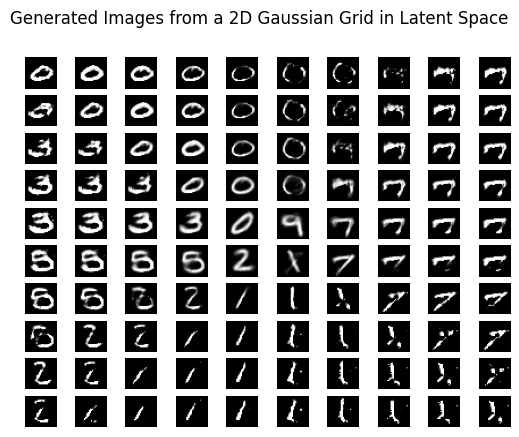

In [ ]:
def loss_function_mse(x, x_hat, mu, var):
    MSE = F.mse_loss(x_hat, x.view(-1, 28*28), reduction='sum')
    KL = -0.5 * torch.sum(1 + var - mu.pow(2) - var.exp())
    return MSE + KL

vae = VAE(latent_dim=200).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (x, label) in enumerate(train_loader):
        x = x.to(x).view(-1, 28*28)
        optimizer.zero_grad()

        x_pred, mu, var = vae(x)
        loss = loss_function_mse(x, x_pred, mu, var)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

vae.to(device)
vae.eval()
with torch.no_grad():
     x_hat = vae.decode(z_tensor).cpu().numpy()

fig, axes = plt.subplots(10, 10)
for i, ax in enumerate(axes.flat):
    ax.imshow(x_hat[i].reshape(28, 28), cmap="gray")
    ax.axis("off")

plt.suptitle("Generated Images from a 2D Gaussian Grid in Latent Space")
plt.show()

<h4><u>Report</u></h4>


*   The above grid visualisation shows that the MSE loss does not make the model learn a lot of useful information.
* BCE loss is better suited for a reconstruction loss in this case because it penalises the every digit that is not the target in the same way. However, in MSE this is not the case because different digits get assigned different penalities, for no specific reason.
* Hence, becase no meaningful assosciation is leanrt, the latent space formed is also not accurate and leads to bad reconstructions.